## Colab Notebook created for ARAP module at UPC ETSETB.

Authors: Juan José Nieto, Josep Vidal, Margarita Cabrera-Bean

# GRID WORLD
[Open to access description of tasks](https://drive.google.com/file/d/1PUpvtq1mXGLIxYcksXuR4Nr7WmV0ILkJ/view)

## Complete the TODOs you'll find in the notebook:

1.  Initialize the variable POLICY p(s'|a,s) (a).
2.  Initialize the corresponding rewards in *next_position* function (a).
3.  Compute the reward vector and the transition probability matrix (b).
4.  Compute Bellman Equation (c)
-------------------------------------------------
5.  Compute update of the state value (IPE,d)
6.  Program Policy Improvement Algorithm (PI,e)
7.  Program Value Iteration Algorithm (VI,f)






In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

We first of all define the class for a grid, and initialize the policy as a random one, with equal probability for each action, that is, $\pi(a\vert s)=\frac{1}{4}$ for all $a\in\mathcal A$, and for all $s\in\mathcal S$.

In [2]:
class Grid():
    def __init__(self):
        self.N_ROWS = 5
        self.N_COLUMNS = 5
        self.N_STATES = self.N_ROWS * self.N_COLUMNS

        self.GAMMA = 0.9
        self.ZETA_MAX = 1e-3
        self.ITER_MAX = 100
        
        self.ACTIONS = [(0, -1), (1, 0), (0, 1), (-1, 0)]
        self.N_ACTIONS = 4
        
        # 1.TODO: Initialize with equal probability for each action in each state (a)
        self.POLICY = np.ones((self.N_STATES, self.N_ACTIONS))/4

        self.SPC_STATES = [(6, 10, 10), (16, 18, 5)] # (ini state, fin state, reward)

        self.TrPrM = np.zeros((self.N_STATES, self.N_STATES))
        self.V_FUNCTION = np.zeros(self.N_STATES)
        self.REWARD = np.zeros(self.N_STATES)


    ''' Convert state s from scalar to coordinates x,y '''
    def get_XY(self, state):
        state -= 1
        return (state % self.N_ROWS, int(state / self.N_ROWS))

    ''' Convert coordinates x,y to scalar state '''
    def get_state(self, state):
        return state[1]*self.N_COLUMNS + state[0] + 1


    '''
    Check if state is special

    Params:
        - int: state [1,...,25]
    Returns:
        - bool: is_special
        - int: next_state
        - int: reward
    '''
    def is_special(self, state):
        for spc in self.SPC_STATES:
            if spc[0] == state:
                return True, spc[1], spc[2]
        return False, None, None



    '''
    Computes next state and reward

    Params:
        - int: state [1,...,25]
    Returns:
        - int: next_state
        - int: reward
    '''
    def next_position(self, state, action):
        (x,y) = self.get_XY(state)
        (ax, ay) = self.ACTIONS[action]

        next_state = (x + ax, y + ay)

        special = self.is_special(state)    # returns (is_special, next_state, reward)

        # 2.TODO: Complete the TODOs with the corresponding rewards(b)
        if special[0]:                                                  # special state
            return special[1], special[2]

        elif next_state[0] > -1 and next_state[0] < self.N_ROWS and \
            next_state[1] > -1 and next_state[1] < self.N_COLUMNS:      # agent within the limits of the grid

            next_state = self.get_state(next_state)
            return next_state, 0

        else:                                                           # agent is trying to overpass the limits of the grid
            return state, -1


### Plot functions

In [3]:
'''Insert title, and axis labels to plots'''
def insert_labels(labels, ax):
    if 'title' in labels:
        ax.set_title(labels['title'])
    if 'xlabel' in labels:
        ax.set_xlabel(labels['xlabel'])
    if 'ylabel' in labels:
	    ax.set_ylabel(labels['ylabel'])


'''Plot for showing value functions'''
def plot_heatmap(data, **kwargs):
    fig, ax = plt.subplots()
    sns.heatmap(data, cmap='coolwarm')
    insert_labels(kwargs, ax)

'''Plot for showing how the difference of state-values decrease over time'''
def plot_deltas(data, **kwargs):
    fig, ax = plt.subplots()
    plt.plot(data)
    insert_labels(kwargs, ax)

'''Policy plots. Indicates action taken in each state.'''
def plot_arrow(data, actions, **kwargs):

    fig, ax = plt.subplots()

    U = np.array([[actions[y][0] for y in x] for x in data])
    V = np.array([[actions[y][1] for y in x] for x in data])

    X = np.arange(0, 5, 1)
    Y = np.arange(0, 5, 1)

    q = ax.quiver(X, Y, V, U*-1)
    plt.imshow(data, cmap=plt.cm.Pastel1)
    

    insert_labels(kwargs, ax)
    ax.axis('off')
    plt.show()


'''Group of N policy plots.'''
def plot_arrows(data, actions):
    # Only pick 3 first actions matrices and last one (optimal policy)
    num_policies = len(data)

    fdata = data[:min(3, num_policies)] + data[-1:]
    

    fig, ax = plt.subplots(1, len(fdata), figsize=(20,6))
    for i, d in enumerate(fdata):

        U = np.array([[actions[y][0] for y in x] for x in d])
        V = np.array([[actions[y][1] for y in x] for x in d])

        X = np.arange(0, 5, 1)
        Y = np.arange(0, 5, 1)
        
        q = ax[i].quiver(X, Y, V, U*-1)
        ax[i].imshow(d, cmap=plt.cm.Pastel1)
        labels = {
            'title': '{} Policy'.format(i if len(fdata)-1 > i else 'Optimal'),
        }
        insert_labels(labels, ax[i])
        ax[i].axis('off')

    plt.show()


## TRANSITION PROBABILITY MATRIX AND OPTIMAL VALUE FUNCTION (b,c)

We now want to obtain the transition probability matrix and the reward vector for the random uniform policy. We will use the following equations, that appear in the theory material of the course:
$$
P^\pi_{ss'}=\sum_{a\in\mathcal A}\pi(a\vert s)\cdot p(s'\vert s, a),\quad R^\pi_s=\sum_{a\in\mathcal A}\pi(a\vert s)\cdot R^a_s.
$$
As our actions determinate the next state $s'$ uniquely, the term $p(s'\vert s,a)$ is 1 for the action that can move a player from $s$ to $s'$, which is unique if it exists, and 0 for the rest of actions.

In [4]:
grid = Grid()

for s in range(1, grid.N_STATES + 1):
    for a in range(grid.N_ACTIONS):
        
        next_state, reward = grid.next_position(s, a)
        # 3.TODO: Compute reward vector and transition prob matrix.
        grid.TrPrM[s-1, next_state-1] += grid.POLICY[s-1, a] # we are omitting a *1 here
        grid.REWARD[s-1] += grid.POLICY[s-1, a]*reward

The following is a heat map of the transition matrix for the grid MDP.

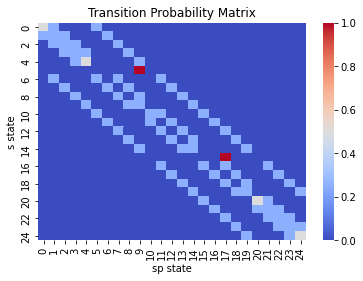

In [5]:
# PLOT TRANSITION MATRIX
conf = {
    'title': 'Transition Probability Matrix',
    'xlabel': 'sp state',
    'ylabel': 's state'
}
plot_heatmap(grid.TrPrM, **conf)

We now want to solve the Bellman optimality equation and obtain the value function given the transition probability matrix and a certain discount factor $\gamma\in(0,1)$, which is 0.9 in our case. This is solved by:
$$
\mathbf v=\left(\text{Id}-\gamma\cdot P^\pi\right)^{-1}R^\pi.
$$

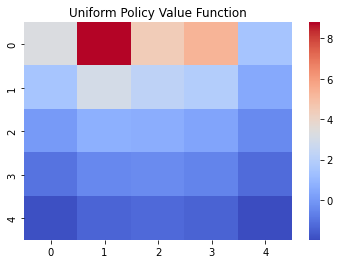

In [6]:
# COMPUTE UNIFORM POLICY VALUE FUNCTION AND PLOT IT

# 4.TODO: Compute Bellman Equation 
aux = np.identity(grid.N_STATES) -  grid.GAMMA*grid.TrPrM
value_f = np.linalg.inv(aux).dot(grid.REWARD)

vf_matrix_exact = np.transpose(np.reshape(value_f, (grid.N_ROWS, grid.N_COLUMNS)))
conf = {
    'title': 'Uniform Policy Value Function',
}
plot_heatmap(vf_matrix_exact, **conf)

## ITERATIVE POLICY EVALUATION (IPE,d)

We now implement the Policy Evaluation procedure, to evaluate an approximation to the value function of a policy $\pi$.

In [7]:
'''
In this case we define a function since we will use this algorithm
within 'policy iteration' algorithm
'''
def policy_evaluation(grid):
    zeta = grid.ZETA_MAX + 1
    iter = 0
    v_incr = []

    while zeta > grid.ZETA_MAX and iter < grid.ITER_MAX + 1:
        
        vm_aux = grid.V_FUNCTION.copy()                                 # Store current state-values for later comparison

        for s in range(1, grid.N_STATES + 1):                           # Loop over all the states
            vs_aux = 0
            for a in range(grid.N_ACTIONS):                             # Loop over all actions in each state
                next_state, reward = grid.next_position(s, a)           # Compute next_state and reward when taking action a in state s

                 # 5.TODO: Compute the update of the state value
                vs_aux += grid.POLICY[s-1, a]*(reward + grid.GAMMA*vm_aux[next_state-1])
        
            grid.V_FUNCTION[s - 1] = vs_aux                             # Update state-value with the result of Bellman Equation
        
        zeta = np.max(np.abs(grid.V_FUNCTION - vm_aux))                 # Compute the difference between current state-values and previous ones
        v_incr.append(zeta)
        iter += 1
    
    return v_incr

In [8]:
grid = Grid()
v_incr = policy_evaluation(grid)

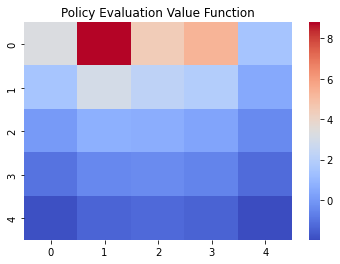

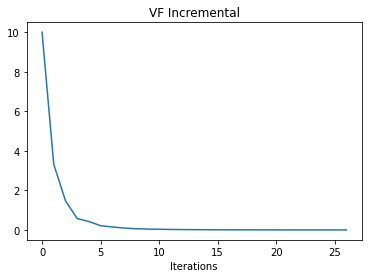

In [9]:
vf_matrix_approx = np.transpose(np.reshape(grid.V_FUNCTION, (grid.N_ROWS, grid.N_COLUMNS)))

conf = {
    'title': 'Policy Evaluation Value Function',
}
plot_heatmap(vf_matrix_approx, **conf)


conf= {
    'title': 'VF Incremental',
    'xlabel': 'Iterations'
}
plot_deltas(v_incr, **conf)


We can see how the resulting approximate value function is very similar to the exact one computed before via matrix inversion. In fact, the error is very low:

In [10]:
print(np.abs(np.max(vf_matrix_approx-vf_matrix_exact)))

0.007230833481413068


## POLICY ITERATION  (PI,e)

Now, we implement Policy Iteration, making use of both policy evaluation and policy improvement:

In [11]:
def policy_improvement(grid):
    # First of all, we calculate the action-state value function q_pi
    q_pi = np.zeros((grid.N_STATES, grid.N_ACTIONS))
    for s in range(1, grid.N_STATES + 1):
        for a in range(grid.N_ACTIONS):
            next_state, reward = grid.next_position(s, a)
            q_pi[s-1, a] = reward + grid.GAMMA*grid.V_FUNCTION[next_state-1]
    
    # Now, once q_pi has been calculated, we take as the new action the position of the maximum in q_pi
    num_diff_actions = 0
    # policy_is_stable = True
    for s in range(1, grid.N_STATES+1):
        old_action = np.argmax(grid.POLICY[s-1])
        new_action = np.argmax(q_pi[s-1])

        grid.POLICY[s-1] = np.zeros(grid.N_ACTIONS)
        grid.POLICY[s-1, new_action] = 1

        if old_action != new_action:
            # policy_is_stable = False
            num_diff_actions += 1
    
    # return policy_is_stable
    return num_diff_actions

We initially set the policy to be a deterministic one, but we set the initial actions from each state at random.

In [12]:
grid = Grid()

iter = 0
it_max = 10
ac_dif = 1

actions_list = []       # Store actions taken in each state for each run. [[a1, ... , a25], ... , [a1, ... , a25]]
a_inc = []              # Store number of different actions taken in each run.

from random import randint

# First of all, we have to initialize the policy as a deterministic policy (randomly)
grid.POLICY = np.zeros((grid.N_STATES, grid.N_ACTIONS))
for s in range(grid.N_STATES):
    random_action = randint(0, grid.N_ACTIONS-1)
    grid.POLICY[s, random_action] = 1

while ac_dif > 0 and iter < it_max + 1:
    ac_dif = 0
    actions = []        # Store actions taken in each state in one run. [a1, ..., a25]
    for s in range(grid.N_STATES):
        actions.append(np.argmax(grid.POLICY[s]))
    
# 6.TODO: Program Policy Iteration Algorithm (you must make use of policy_evaluation function)

    # Now, we evaluate the deterministic policy that we have just initialized
    _ = policy_evaluation(grid) # we are not interested in how the convergence works

    # Right after that, we have to improve the policy using the policy_improvement function defined above
    ac_dif = policy_improvement(grid)
    #####

    actions_list.append(np.transpose(np.array(actions).reshape(grid.N_ROWS,grid.N_COLUMNS)))
    a_inc.append(ac_dif)

    iter += 1

We are using the default values of $\theta=0.001$ and 100 maximum iterations for policy evaluation, and the results are good:

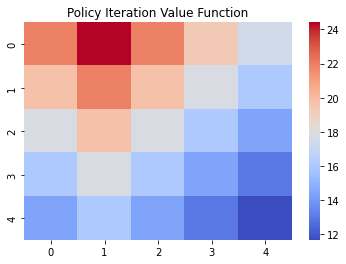

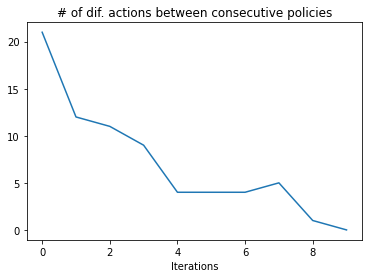

In [13]:
vf_matrix_PI = np.transpose(np.reshape(grid.V_FUNCTION, (grid.N_ROWS, grid.N_COLUMNS)))

conf = {
    'title': 'Policy Iteration Value Function',
}
plot_heatmap(vf_matrix_PI, **conf)


conf= {
    'title': '# of dif. actions between consecutive policies',
    'xlabel': 'Iterations'
}
plot_deltas(a_inc, **conf)



The value function obtained here is quite different from the one obtained with the exact solution of the Bellman Optimality Equation.

In [18]:
print(np.abs(np.max(vf_matrix_PI - vf_matrix_exact)))

19.040575969968863


The difference is now significantly bigger than before, when we calculated the value function using policy evaluation. Still, the final result of the resultin policy is correct, as we can see below:

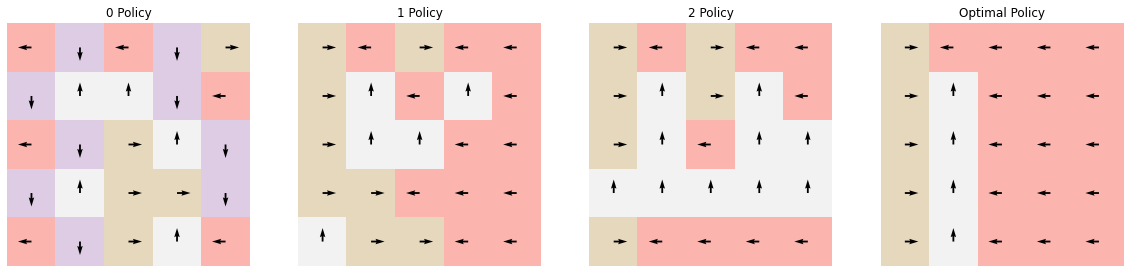

In [14]:
plot_arrows(actions_list, grid.ACTIONS)

## VALUE ITERATION (VI,f)

In [15]:

grid = Grid()
zeta = grid.ZETA_MAX + 1
iter = 0
v_incr = []
a_inc = []
action_taken_before = np.random.randint(0, 4, size=grid.N_STATES) # according to the random uniform policy that Grid() initializes

while zeta > grid.ZETA_MAX and iter < grid.ITER_MAX + 1:
    ac_dif = 0
    vm_aux = grid.V_FUNCTION.copy()

    # 7.TODO: Program Value Iteration Algorithm (do NOT make use of policy_evaluation function)
    for s in range(1, grid.N_STATES+1):
        aux_bellman_optimality_equation = np.zeros(grid.N_ACTIONS)
        for a in range(grid.N_ACTIONS):
            next_state, r = grid.next_position(s, a)
            aux_bellman_optimality_equation[a] = r + grid.GAMMA*vm_aux[next_state-1]
        
        action_taken = np.argmax(aux_bellman_optimality_equation)
        if action_taken != action_taken_before[s-1]:
            ac_dif += 1
            action_taken_before[s-1] = action_taken
            
        grid.V_FUNCTION[s-1] = aux_bellman_optimality_equation[action_taken]




    a_inc.append(ac_dif)                                # Number of actions taken differently from previous iteration
    zeta = np.max(np.abs(grid.V_FUNCTION - vm_aux))     # Compute the difference of the state-values
    v_incr.append(zeta)                                 # Store the difference in v_incr list
    iter += 1

for s in range(grid.N_STATES):
    grid.POLICY[s] = np.zeros(grid.N_ACTIONS)
    grid.POLICY[s, action_taken_before[s]] = 1

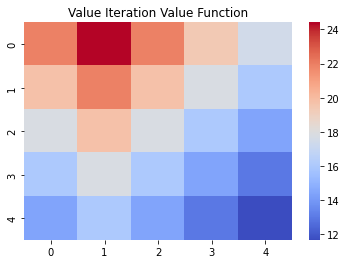

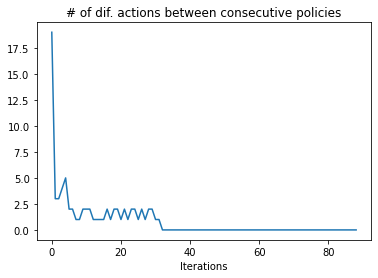

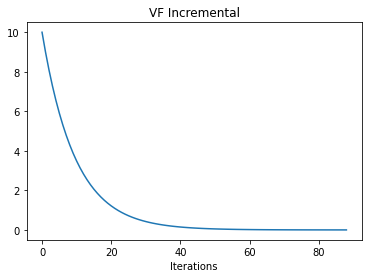

In [16]:
vf_matrix = np.transpose(np.reshape(grid.V_FUNCTION, (grid.N_ROWS, grid.N_COLUMNS)))

conf = {
    'title': 'Value Iteration Value Function',
}
plot_heatmap(vf_matrix, **conf)


conf= {
    'title': '# of dif. actions between consecutive policies',
    'xlabel': 'Iterations'
}
plot_deltas(a_inc, **conf)

conf= {
    'title': 'VF Incremental',
    'xlabel': 'Iterations'
}
plot_deltas(v_incr, **conf)


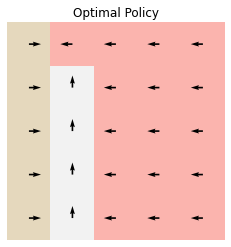

In [17]:
conf= {
    'title': 'Optimal Policy'
}

actions = [np.argmax(grid.POLICY[s-1]) for s in range(1, grid.N_STATES + 1)]
action_arrows = np.transpose(np.array(actions).reshape(grid.N_ROWS,grid.N_COLUMNS))
plot_arrow(action_arrows, grid.ACTIONS, **conf)